In [1]:
pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K  

import tqdm


import math

os.environ["CUDA_VISIBLE_DEVICES"]="2"
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

per_process_gpu_memory_fraction: 0.333

## dataset read and processing

In [3]:
original_data=pd.read_hdf("/Users/bolit/OneDrive/Documentos/Tec/7_semestre/investigacion/CWoaLaSimulation/content/events_anomalydetection_v2.features.h5")
features_sig=original_data.query("label == 1")
features_bg=original_data.query("label == 0")


features_bg2=pd.read_hdf("/Users/bolit/OneDrive/Documentos/Tec/7_semestre/investigacion/CWoaLaSimulation/content/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [4]:
features_sig

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
1000000,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635600,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901,1.0
1000001,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801,1.0
1000002,420.975006,-1739.790039,281.553986,93.665802,77.925797,10.605900,6.916510,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300,1.0
1000003,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.179993,102.625000,53.422699,1.0
1000004,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [5]:
alpha = 0.1

def load_dataT21(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

def load_dataT32(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"] 
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau32jOne", "tau32jTwo"]]
    return dataset.to_numpy()

def load_data_more(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    
    #Masa ya al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #tau32
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]   
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    return dataset.to_numpy()

column_labelsT21 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", 
    r"$\tau_{2,1}^{J_2}$",
]

column_labelsT32 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{3,2}^{J_1}$", 
    r"$\tau_{3,2}^{J_2}$",
]

In [6]:
dataset_bgT21=load_dataT21(features_bg)
dataset_bg2T21=load_dataT21(features_bg2)
dataset_sigT21=load_dataT21(features_sig)

dataset_bgT32=load_dataT32(features_bg)
dataset_bg2T32=load_dataT32(features_bg2)
dataset_sigT32=load_dataT32(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\259476259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\259476259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\259476259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\259476259.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
C:\Users\bolit\AppData

In [7]:
dataset_bg_more=load_data_more(features_bg)
dataset_bg2_more=load_data_more(features_bg2)
dataset_sig_more=load_data_more(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\259476259.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\259476259.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

## data preparation CWoLa T_21

making it machine-learnable, setting params for ML methods, setting signal significance

In [8]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT21, bg2_srsbT21, sig_srsbT21 = sr_crit(dataset_bgT21), sr_crit(dataset_bg2T21), sr_crit(dataset_sigT21)

SR_background_dataT21 = dataset_bgT21[bg_srsbT21]
SB_background_dataT21 = dataset_bgT21[~bg_srsbT21]
print(~bg_srsbT21)

SR_background_simT21 = dataset_bg2T21[bg2_srsbT21]
SB_background_simT21 = dataset_bg2T21[~bg2_srsbT21]

SR_signalT21 = dataset_sigT21[sig_srsbT21]
SB_signalT21 = dataset_sigT21[~sig_srsbT21]

N_inputs = len(SR_background_dataT21.T) - 1


((SR_background_dataT21, SR_background_data_fortestT21),
 (SR_background_simT21, SR_background_sim_fortestT21),
 (SB_background_dataT21, SB_background_data_fortestT21),
 (SB_background_simT21, SB_background_sim_fortestT21),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT21, SR_background_simT21,
    SB_background_dataT21, SB_background_simT21,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT21, SB_background_simT21, SR_background_dataT21, 
                                      SR_background_simT21]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT21)*Nsig/len(SR_signalT21)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)))

n_injectionsT21 = 20
SR_signals_to_injectT21 = [None] * n_injectionsT21
SB_signals_to_injectT21 = [None] * n_injectionsT21
signals_to_testT21 = [None] * n_injectionsT21

for i in range(n_injectionsT21):
    idx = np.isin(range(len(SR_signalT21)), np.random.choice(SR_signalT21.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT21[i] = SR_signalT21[idx, :]
    signals_to_testT21[i] = SR_signalT21[~idx, :]
    
    idx = np.isin(range(len(SB_signalT21)), np.random.choice(SB_signalT21.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT21[i] = SB_signalT21[idx, :]

[False  True  True ...  True  True  True]
     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


## CWoLa T_21

With relu activation

In [9]:
#CWoLa with T21 and relu 
cwola_rocsT21 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21 = Sequential()
    model_cwolaT21.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(1, activation='sigmoid'))
    model_cwolaT21.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21 = model_cwolaT21.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21 = model_cwolaT21.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21, tpr_cwolaT21, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21)
    cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:24<26:43, 84.40s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [02:54<26:19, 87.77s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:25<25:13, 89.04s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [05:55<23:51, 89.49s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:25<22:24, 89.61s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [08:54<20:53, 89.55s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:23<19:21, 89.37s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [11:51<17:48, 89.07s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [13:21<16:21, 89.27s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [14:57<15:13, 91.36s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [16:29<13:42, 91.44s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [17:59<12:09, 91.16s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:36<10:50, 92.89s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:15<09:28, 94.68s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:59<08:07, 97.40s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:33<06:26, 96.60s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:07<04:47, 95.70s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:42<03:10, 95.36s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:15<01:34, 94.83s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [30:48<00:00, 92.45s/it]


## data preparation CWoLa T_32

making it machine-learnable, setting params for ML methods, setting signal significance

In [10]:
SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT32, bg2_srsbT32, sig_srsbT32 = sr_crit(dataset_bgT32), sr_crit(dataset_bg2T32), sr_crit(dataset_sigT32)

SR_background_dataT32 = dataset_bgT32[bg_srsbT32]
SB_background_dataT32 = dataset_bgT32[~bg_srsbT32]

SR_background_simT32 = dataset_bg2T32[bg2_srsbT32]
SB_background_simT32 = dataset_bg2T32[~bg2_srsbT32]

SR_signalT32 = dataset_sigT32[sig_srsbT32]
SB_signalT32 = dataset_sigT32[~sig_srsbT32]

N_inputs = len(SR_background_dataT32.T) - 1


((SR_background_dataT32, SR_background_data_fortestT32),
 (SR_background_simT32, SR_background_sim_fortestT32),
 (SB_background_dataT32, SB_background_data_fortestT32),
 (SB_background_simT32, SB_background_sim_fortestT32),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT32, SR_background_simT32,
    SB_background_dataT32, SB_background_simT32,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT32, SB_background_simT32, SR_background_dataT32, 
                                      SR_background_simT32]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT32)*Nsig/len(SR_signalT32)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT32[0:Nsig])/len(SR_background_dataT32)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT32[0:Nsig])/len(SR_background_dataT32)))

n_injectionsT32 = 20
SR_signals_to_injectT32 = [None] * n_injectionsT32
SB_signals_to_injectT32 = [None] * n_injectionsT32
signals_to_testT32 = [None] * n_injectionsT32

for i in range(n_injectionsT32):
    idx = np.isin(range(len(SR_signalT32)), np.random.choice(SR_signalT32.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT32[i] = SR_signalT32[idx, :]
    signals_to_testT32[i] = SR_signalT32[~idx, :]
    
    idx = np.isin(range(len(SB_signalT32)), np.random.choice(SB_signalT32.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT32[i] = SB_signalT32[idx, :]

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


## CWoLa T_32

With relu activation

In [11]:
#CWoLa with T32 and relu
cwola_rocsT32 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT32)):
    
    SR_signal_to_injectT32 = SR_signals_to_injectT32[i]
    SB_signal_to_injectT32 = SB_signals_to_injectT32[i]

    signal_to_testT32 = signals_to_testT32[i]
        
    X_cwola_trainT32 = np.concatenate([SR_signal_to_injectT32, SR_background_dataT32, SB_signal_to_injectT32, SB_background_dataT32])
    Y_cwola_trainT32 = np.concatenate([np.ones(len(SR_signal_to_injectT32)), np.ones(len(SR_background_dataT32)),
                                    np.zeros(len(SB_signal_to_injectT32)), np.zeros(len(SB_background_dataT32))])
    
    X_cwola_trainT32, Y_cwola_trainT32 = shuffle(X_cwola_trainT32, Y_cwola_trainT32, )

    sbmjjT32 = X_cwola_trainT32[:,0]
    sb_critT32 = ((sbmjjT32 > SR_low - SB_width)&(sbmjjT32 <= SR_high + SB_width))
    
    X_cwola_trainT32 = X_cwola_trainT32[sb_critT32]
    Y_cwola_trainT32 = Y_cwola_trainT32[sb_critT32]
    
    w_lowT32 = 0.5*(len(SR_signal_to_injectT32) + len(SR_background_dataT32))/((X_cwola_trainT32[:,0] <= SR_low).sum())
    w_highT32 = 0.5*(len(SR_signal_to_injectT32) + len(SR_background_dataT32))/((X_cwola_trainT32[:,0] >= SR_high).sum())

    W_cwola_trainT32 = np.ones_like(Y_cwola_trainT32)
    W_cwola_trainT32[(Y_cwola_trainT32 == 0) & (X_cwola_trainT32[:,0] <= SR_low)] = w_lowT32
    W_cwola_trainT32[(Y_cwola_trainT32 == 0) & (X_cwola_trainT32[:,0] >= SR_high)] = w_highT32
    
    X_cwola_valT32 = np.concatenate([signal_to_testT32,SR_background_data_fortestT32])
    Y_cwola_valT32 = np.concatenate([np.ones(len(signal_to_testT32)),np.zeros(len(SR_background_data_fortestT32))])
    
    K.clear_session()
    model_cwolaT32 = Sequential()
    model_cwolaT32.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT32.add(Dense(64, activation='relu'))
    model_cwolaT32.add(Dense(64, activation='relu'))
    model_cwolaT32.add(Dense(1, activation='sigmoid'))
    model_cwolaT32.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT32 = model_cwolaT32.fit(X_cwola_trainT32[:,1:], Y_cwola_trainT32, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT32)

    scores_cwolaT32 = model_cwolaT32.predict(X_cwola_valT32[:,1:],batch_size=batch_size)
        
    fpr_cwolaT32, tpr_cwolaT32, _ = roc_curve(Y_cwola_valT32, scores_cwolaT32)
    cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:32<29:19, 92.60s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:04<27:37, 92.07s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:35<25:57, 91.64s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:08<24:35, 92.24s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:39<22:56, 91.79s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:10<21:21, 91.56s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:38<19:35, 90.44s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:07<18:00, 90.01s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [13:39<16:34, 90.44s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:09<15:05, 90.51s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [16:38<13:30, 90.01s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:07<11:56, 89.58s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:41<10:35, 90.85s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:13<09:08, 91.37s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:49<07:43, 92.62s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:21<06:10, 92.58s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:51<04:35, 91.84s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:23<03:03, 91.92s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [28:58<01:32, 92.81s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [30:33<00:00, 91.66s/it]


In [12]:
 with np.errstate(divide='ignore'):
    tpr_pts = np.linspace(0, 1, 10000)
    
    # CWoLa T21
    fpr_interp = [None] * len(cwola_rocsT21)

    for i, row in cwola_rocsT21.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21 = np.median(fpr_interp, axis=0).data
    cwola_meanT21 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21 = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T32
    fpr_interp = [None] * len(cwola_rocsT32)

    for i, row in cwola_rocsT32.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT32 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT32 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT32 = np.median(fpr_interp, axis=0).data
    cwola_meanT32 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT32 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT32 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT32 = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Plotting

In [13]:
bands = {'cwola_T21': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'$T_{21}$', 'color':'blue'}),
         'cwola_T32': (cwola_maxT32, cwola_medT32, cwola_minT32, cwola_meanT32, cwola_stdT32, cwola_smeanT32, cwola_sstdT32, {'label':'$T_{32}$', 'color':'red'}),}

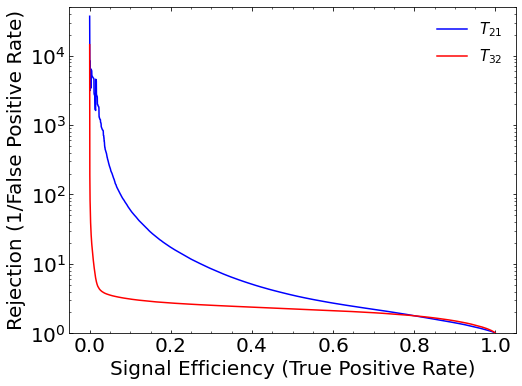

In [14]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

With T_21 is better

## selu activation

In [15]:
#CWoLa with T21 and selu 
cwola_rocsT21_selu = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21_selu = Sequential()
    model_cwolaT21_selu.add(Dense(64, input_dim=N_inputs, activation='selu')) 
    model_cwolaT21_selu.add(Dense(64, activation='selu'))
    model_cwolaT21_selu.add(Dense(64, activation='selu'))
    model_cwolaT21_selu.add(Dense(1, activation='sigmoid'))
    model_cwolaT21_selu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21_selu = model_cwolaT21_selu.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21_selu = model_cwolaT21_selu.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21_selu, tpr_cwolaT21_selu, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21_selu)
    cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
  5%|████                                                                              | 1/20 [01:40<31:42, 100.13s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:18<29:47, 99.29s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:57<28:06, 99.21s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 20%|████████████████▍                                                                 | 4/20 [06:40<26:49, 100.56s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 25%|████████████████████▌                                                             | 5/20 [08:23<25:19, 101.32s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 30%|████████████████████████▌                                                         | 6/20 [10:05<23:41, 101.52s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 35%|████████████████████████████▋                                                     | 7/20 [11:48<22:06, 102.04s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 40%|████████████████████████████████▊                                                 | 8/20 [13:32<20:31, 102.60s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 45%|████████████████████████████████████▉                                             | 9/20 [15:11<18:39, 101.75s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 50%|████████████████████████████████████████▌                                        | 10/20 [16:51<16:50, 101.03s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 55%|████████████████████████████████████████████▌                                    | 11/20 [18:29<15:01, 100.17s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 60%|████████████████████████████████████████████████▌                                | 12/20 [20:24<13:56, 104.60s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 65%|████████████████████████████████████████████████████▋                            | 13/20 [22:00<11:53, 101.95s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [23:35<09:59, 99.91s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [25:08<08:10, 98.00s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [26:46<06:31, 97.86s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [28:27<04:56, 98.90s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [30:05<03:16, 98.42s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [31:46<01:39, 99.21s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [33:27<00:00, 100.37s/it]


## elu activation

In [16]:
#CWoLa with T21 and elu 

cwola_rocsT21_elu = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21_elu = Sequential()
    model_cwolaT21_elu.add(Dense(64, input_dim=N_inputs, activation='elu')) 
    model_cwolaT21_elu.add(Dense(64, activation='elu'))
    model_cwolaT21_elu.add(Dense(64, activation='elu'))
    model_cwolaT21_elu.add(Dense(1, activation='sigmoid'))
    model_cwolaT21_elu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21_elu = model_cwolaT21_elu.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21_elu = model_cwolaT21_elu.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21_elu, tpr_cwolaT21_elu, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21_elu)
    cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:39<31:26, 99.29s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:18<29:47, 99.28s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:53<27:30, 97.12s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:25<25:23, 95.25s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:55<23:22, 93.52s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:26<21:33, 92.40s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:59<20:03, 92.58s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:31<18:29, 92.48s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [14:01<16:50, 91.82s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:31<15:10, 91.09s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [17:01<13:36, 90.73s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:31<12:03, 90.49s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [20:03<10:36, 90.99s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:35<09:08, 91.39s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [23:07<07:38, 91.65s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:39<06:06, 91.70s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:15<04:38, 92.94s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:56<03:11, 95.53s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:31<01:35, 95.25s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [31:01<00:00, 93.07s/it]


## leaky relu

In [17]:
#CWoLa with T21 and leaky relu

cwola_rocsT21_lrelu = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21_lrelu = Sequential()
    model_cwolaT21_lrelu.add(Dense(64, input_dim=N_inputs, activation='leaky_relu')) 
    model_cwolaT21_lrelu.add(Dense(64, activation='leaky_relu'))
    model_cwolaT21_lrelu.add(Dense(64, activation='leaky_relu'))
    model_cwolaT21_lrelu.add(Dense(1, activation='sigmoid'))
    model_cwolaT21_lrelu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21_lrelu = model_cwolaT21_lrelu.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21_lrelu = model_cwolaT21_lrelu.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21_lrelu, tpr_cwolaT21_lrelu, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21_lrelu)
    cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:28<27:55, 88.18s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [02:57<26:40, 88.90s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:27<25:20, 89.47s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [05:57<23:55, 89.71s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:27<22:27, 89.84s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [08:58<21:00, 90.02s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:29<19:35, 90.43s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:01<18:10, 90.83s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [13:33<16:45, 91.43s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:04<15:12, 91.27s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [16:35<13:40, 91.15s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:07<12:09, 91.20s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:38<10:37, 91.13s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:08<09:06, 91.07s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:38<07:33, 90.62s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:08<06:01, 90.33s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:39<04:31, 90.54s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:08<03:00, 90.10s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [28:38<01:30, 90.14s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [30:11<00:00, 90.57s/it]


In [18]:
with np.errstate(divide='ignore'):
    tpr_pts = np.linspace(0, 1, 10000)
    
    # CWoLa T21 selu
    fpr_interp = [None] * len(cwola_rocsT21_selu)

    for i, row in cwola_rocsT21_selu.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21_selu = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21_selu = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21_selu = np.median(fpr_interp, axis=0).data
    cwola_meanT21_selu = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21_selu = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21_selu = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21_selu = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T21 elu
    fpr_interp = [None] * len(cwola_rocsT21_elu)

    for i, row in cwola_rocsT21_elu.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21_elu = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21_elu = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21_elu = np.median(fpr_interp, axis=0).data
    cwola_meanT21_elu = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21_elu = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21_elu = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21_elu = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T21 leaky relu
    fpr_interp = [None] * len(cwola_rocsT21_lrelu)

    for i, row in cwola_rocsT21_lrelu.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21_lrelu = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21_lrelu = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21_lrelu = np.median(fpr_interp, axis=0).data
    cwola_meanT21_lrelu = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21_lrelu = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21_lrelu = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21_lrelu = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [19]:
bands2 = {'cwola_T21relu': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'ReLU', 'color':'blue'}),
          'cwola_T21selu': (cwola_maxT21_selu, cwola_medT21_selu, cwola_minT21_selu, cwola_meanT21_selu, cwola_stdT21_selu, cwola_smeanT21_selu, cwola_sstdT21_selu, {'label':'SELU', 'color':'red'}),
          'cwola_T21elu': (cwola_maxT21_elu, cwola_medT21_elu, cwola_minT21_elu, cwola_meanT21_elu, cwola_stdT21_elu, cwola_smeanT21_elu, cwola_sstdT21_elu, {'label':'ELU', 'color':'orange'}),
          'cwola_T21lrelu': (cwola_maxT21_lrelu, cwola_medT21_lrelu, cwola_minT21_lrelu, cwola_meanT21_lrelu, cwola_stdT21_lrelu, cwola_smeanT21_lrelu, cwola_sstdT21_lrelu, {'label':'Leaky ReLU', 'color':'green'}),
         }

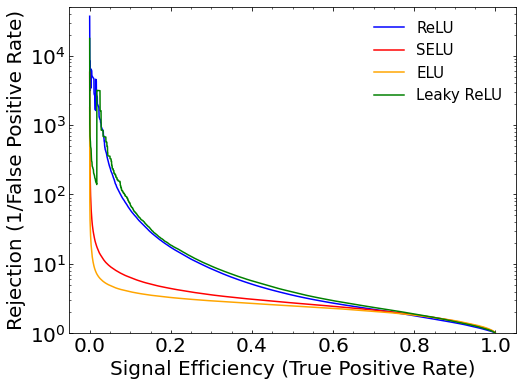

In [20]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands2:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands2[band][3:5]

    plt.plot(tpr_pts, mu, **bands2[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

## Models for AUC

In [21]:
#initial data

SR_low = 3.3
SR_high = 3.7
SB_low = 3.1
SB_high = 3.9
SB_width = 0.3
test_size = 0.5
EPOCHS=20
batch_size = 200

#mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

## 2 layers

In [22]:
from tensorflow.keras.callbacks import Callback

class AUCRecordsL2(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_2lay, aucsSB_foravg_2lay, aucs_foravg_2lay, aucsSB_foravg_2lay, aucs_2lay, aucs_std_2lay, aucsSB_2lay, aucsSB_std_2lay, num_epochs
        preds_hold_2lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_2lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_2lay = roc_auc_score(Y_test, preds_hold_2lay)
        print(myauc_scan_2lay)
        myaucSB_scan_2lay = roc_auc_score(Y_testSB, preds_holdSB_2lay)
        print(myaucSB_scan_2lay)
        
        aucs_foravg_2lay += [myauc_scan_2lay]
        print(aucs_foravg_2lay)
        aucsSB_foravg_2lay += [myaucSB_scan_2lay]
        print(aucsSB_foravg_2lay)
        
        aucs_2lay+=[np.mean(aucs_foravg_2lay)]
        print(aucs_2lay)
        aucs_std_2lay += [np.std(aucs_foravg_2lay)]
        print(aucs_std_2lay)
        aucsSB_2lay+=[np.mean(aucsSB_foravg_2lay)]
        print(aucsSB_2lay)
        aucsSB_std_2lay += [np.std(aucsSB_foravg_2lay)]
        print(aucsSB_std_2lay)
        
        print(f"epoch {epoch}")

In [23]:
    lambdas_2lay = []
    num_epochs = []
    aucs_2lay = []
    aucs_std_2lay = []
    aucsSB_2lay = []
    aucsSB_std_2lay = []
    aucs_foravg_2lay =[]
    aucsSB_foravg_2lay = []

    for k in range(1):
        model_cwola_scan_2lay = Sequential()
        model_cwola_scan_2lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_2lay.add(Dense(100, activation='relu'))
        model_cwola_scan_2lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_2lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_2lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_2lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_2lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_2lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_2lay = X_kcwola_train_2lay[sb_crit]
        Y_kcwola_train_2lay = Y_kcwola_train_2lay[sb_crit]
        W_kcwola_train_2lay = W_kcwola_train_2lay[sb_crit]


        X_kcwola_train_2lay, Y_kcwola_train_2lay, W_kcwola_train_2lay = shuffle(X_kcwola_train_2lay, Y_kcwola_train_2lay, 
                                                                       W_kcwola_train_2lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_2lay.fit(norm_func(X_kcwola_train_2lay)[:,1:],Y_kcwola_train_2lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_2lay, verbose=2, callbacks=[AUCRecordsL2()])

        pass
        

    
    

epoch 0
Epoch 1/20
50/50 [==============================] - 0s 4ms/step
0.8902585110237611
0.45332188788496774
[0.8902585110237611]
[0.45332188788496774]
[0.8902585110237611]
[0.0]
[0.45332188788496774]
[0.0]
epoch 0
1626/1626 - 6s - loss: 0.6555 - accuracy: 0.5095 - auc: 0.5135 - val_loss: 0.6622 - val_accuracy: 0.7257 - val_auc: 0.8885 - 6s/epoch - 4ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 0s 4ms/step
0.8786893223413965
0.41791782391320736
[0.8902585110237611, 0.8786893223413965]
[0.45332188788496774, 0.41791782391320736]
[0.8902585110237611, 0.8844739166825788]
[0.0, 0.005784594341182281]
[0.45332188788496774, 0.4356198558990876]
[0.0, 0.01770203198588019]
epoch 1
1626/1626 - 5s - loss: 0.6553 - accuracy: 0.5130 - auc: 0.5177 - val_loss: 0.6617 - val_accuracy: 0.8016 - val_auc: 0.8771 - 5s/epoch - 3ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 0s 4ms/step
0.8771655698196272
0.4381928886701479
[0.8902585110237611, 0.8786893223413965, 0

50/50 [==============================] - 0s 4ms/step
0.9002262228968383
0.3185373487978902
[0.8902585110237611, 0.8786893223413965, 0.8771655698196272, 0.8702935059586548, 0.9036830912932879, 0.9019214011111716, 0.913501671572385, 0.9102907039412376, 0.916534116390073, 0.9002262228968383]
[0.45332188788496774, 0.41791782391320736, 0.4381928886701479, 0.34756415769506893, 0.37924494867139985, 0.34507006813023333, 0.38219693494987206, 0.3124300198868272, 0.33271299433216855, 0.3185373487978902]
[0.8902585110237611, 0.8844739166825788, 0.8820378010615949, 0.8791017272858599, 0.8840180000873454, 0.8870019002579831, 0.8907875818743263, 0.8932254721326902, 0.8958153214946216, 0.8962564116348434]
[0.0, 0.005784594341182281, 0.005846110367782596, 0.00717595585785602, 0.011741994166819663, 0.012625912124925745, 0.014920743587997828, 0.015375408220571266, 0.016241758399786907, 0.015465002066975311]
[0.45332188788496774, 0.4356198558990876, 0.436477533489441, 0.414249189540848, 0.4072483413669584

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 4ms/step
0.9228725303291418
0.34150156151123356
[0.8902585110237611, 0.8786893223413965, 0.8771655698196272, 0.8702935059586548, 0.9036830912932879, 0.9019214011111716, 0.913501671572385, 0.9102907039412376, 0.916534116390073, 0.9002262228968383, 0.9103269517181617, 0.9046098098047817, 0.9186886186273112, 0.915322132104287, 0.9228725303291418]
[0.45332188788496774, 0.41791782391320736, 0.4381928886701479, 0.34756415769506893, 0.37924494867139985, 0.34507006813023333, 0.38219693494987206, 0.3124300198868272, 0.33271299433216855, 0.3185373487978902, 0.3841081234448225, 0.31139515076822266, 0.32457097659765893, 0.3769651883507714, 0.34150156151123356]
[0.8902585110237611, 0.8844739166825788, 0.8820378010615949, 0.8791017272858599, 0.8840180000873454, 0.8870019002579831, 0.8907875818743263, 0.8932254721326902, 0.8958153214946216, 0.8962564116348434, 0.8975355516424177, 0.8981250731559481, 0.899706884346053, 0.9008222591859267

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 4ms/step
0.9084704602380796
0.35877424806356867
[0.8902585110237611, 0.8786893223413965, 0.8771655698196272, 0.8702935059586548, 0.9036830912932879, 0.9019214011111716, 0.913501671572385, 0.9102907039412376, 0.916534116390073, 0.9002262228968383, 0.9103269517181617, 0.9046098098047817, 0.9186886186273112, 0.915322132104287, 0.9228725303291418, 0.9040041579887441, 0.9096456683724461, 0.9132513087931627, 0.9084704602380796]
[0.45332188788496774, 0.41791782391320736, 0.4381928886701479, 0.34756415769506893, 0.37924494867139985, 0.34507006813023333, 0.38219693494987206, 0.3124300198868272, 0.33271299433216855, 0.3185373487978902, 0.3841081234448225, 0.31139515076822266, 0.32457097659765893, 0.3769651883507714, 0.34150156151123356, 0.33191871754638463, 0.36924867297979297, 0.35960670892975544, 0.35877424806356867]
[0.8902585110237611, 0.8844739166825788, 0.8820378010615949, 0.8791017272858599, 0.8840180000873454, 0.88700190025

In [24]:
aucs_2lay = np.asarray(aucs_2lay)
aucs_std_2lay = np.asarray(aucs_std_2lay)

aucsSB_2lay = np.asarray(aucsSB_2lay)
aucsSB_std_2lay = np.asarray(aucsSB_std_2lay)

print(aucs_2lay)
print(aucsSB_2lay)

[0.89025851 0.88447392 0.8820378  0.87910173 0.884018   0.8870019
 0.89078758 0.89322547 0.89581532 0.89625641 0.89753555 0.89812507
 0.89970688 0.90082226 0.90229228 0.90239927 0.90282553 0.90340474
 0.90367136 0.90439363]
[0.45332189 0.43561986 0.43647753 0.41424919 0.40724834 0.3968853
 0.39478696 0.38449234 0.37873908 0.37271891 0.37375429 0.3685577
 0.3651741  0.36601632 0.364382   0.36235305 0.36275867 0.36258357
 0.36238307 0.36287465]


(0.0, 1.0)

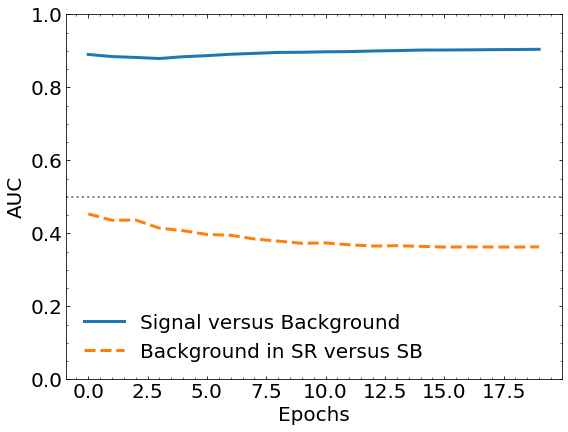

In [25]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

## 3 layers

In [26]:
class AUCRecordsL3(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_3lay, aucsSB_foravg_3lay, aucs_foravg_3lay, aucsSB_foravg_3lay, aucs_3lay, aucs_std_3lay, aucsSB_3lay, aucsSB_std_3lay, num_epochs
        preds_hold_3lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_3lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_3lay = roc_auc_score(Y_test, preds_hold_3lay)
        print(myauc_scan_3lay)
        myaucSB_scan_3lay = roc_auc_score(Y_testSB, preds_holdSB_3lay)
        print(myaucSB_scan_3lay)
        
        aucs_foravg_3lay += [myauc_scan_3lay]
        print(aucs_foravg_3lay)
        aucsSB_foravg_3lay += [myaucSB_scan_3lay]
        print(aucsSB_foravg_3lay)
        
        aucs_3lay+=[np.mean(aucs_foravg_3lay)]
        print(aucs_3lay)
        aucs_std_3lay += [np.std(aucs_foravg_3lay)]
        print(aucs_std_3lay)
        aucsSB_3lay+=[np.mean(aucsSB_foravg_3lay)]
        print(aucsSB_3lay)
        aucsSB_std_3lay += [np.std(aucsSB_foravg_3lay)]
        print(aucsSB_std_3lay)
        
        print(f"epoch {epoch}")

In [27]:
    lambdas_3lay = []
    num_epochs = []
    aucs_3lay = []
    aucs_std_3lay = []
    aucsSB_3lay = []
    aucsSB_std_3lay = []
    aucs_foravg_3lay =[]
    aucsSB_foravg_3lay = []

    for k in range(1):
        model_cwola_scan_3lay = Sequential()
        model_cwola_scan_3lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_3lay.add(Dense(100, activation='relu'))
        model_cwola_scan_3lay.add(Dense(64, activation='relu'))
        model_cwola_scan_3lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_3lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_3lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_3lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_3lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_3lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_3lay = X_kcwola_train_3lay[sb_crit]
        Y_kcwola_train_3lay = Y_kcwola_train_3lay[sb_crit]
        W_kcwola_train_3lay = W_kcwola_train_3lay[sb_crit]


        X_kcwola_train_3lay, Y_kcwola_train_3lay, W_kcwola_train_3lay = shuffle(X_kcwola_train_3lay, Y_kcwola_train_3lay, 
                                                                       W_kcwola_train_3lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_3lay.fit(norm_func(X_kcwola_train_3lay)[:,1:],Y_kcwola_train_3lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_3lay, verbose=2, callbacks=[AUCRecordsL3()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 0s 6ms/step
0.8906700319058606
0.46571783199579225
[0.8906700319058606]
[0.46571783199579225]
[0.8906700319058606]
[0.0]
[0.46571783199579225]
[0.0]
epoch 0
1626/1626 - 7s - loss: 0.6555 - accuracy: 0.5103 - auc: 0.5133 - val_loss: 0.6651 - val_accuracy: 0.8063 - val_auc: 0.8891 - 7s/epoch - 4ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 0s 6ms/step
0.8946122861420979
0.4659784590121681
[0.8906700319058606, 0.8946122861420979]
[0.46571783199579225, 0.4659784590121681]
[0.8906700319058606, 0.8926411590239792]
[0.0, 0.001971127118118643]
[0.46571783199579225, 0.4658481455039802]
[0.0, 0.0001303135081879292]
epoch 1
1626/1626 - 5s - loss: 0.6553 - accuracy: 0.5121 - auc: 0.5172 - val_loss: 0.6713 - val_accuracy: 0.7818 - val_auc: 0.8918 - 5s/epoch - 3ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 0s 5ms/step
0.9048874327817471
0.4690813273687189
[0.8906700319058606, 0.8946122861420979, 0

epoch 9
Epoch 10/20
50/50 [==============================] - 0s 6ms/step
0.9182536953245604
0.3408498106561261
[0.8906700319058606, 0.8946122861420979, 0.9048874327817471, 0.8861304396554665, 0.8956104660840577, 0.8944373185436767, 0.897258468020022, 0.901205171737367, 0.9028560518946839, 0.9182536953245604]
[0.46571783199579225, 0.4659784590121681, 0.4690813273687189, 0.34221945569316387, 0.4080875003636422, 0.33849794716928255, 0.3555618583733652, 0.3454695519240797, 0.34336839037852745, 0.3408498106561261]
[0.8906700319058606, 0.8926411590239792, 0.8967232502765685, 0.894075047621293, 0.8943821313138459, 0.8943913291854844, 0.8948009204475611, 0.8956014518587869, 0.8964075185294421, 0.898592136208954]
[0.0, 0.001971127118118643, 0.005993093196849229, 0.006926529178442496, 0.0062256442835083355, 0.005683246896935771, 0.005356463409909647, 0.005439778627067619, 0.005612595581714982, 0.008444175264536995]
[0.46571783199579225, 0.4658481455039802, 0.46692587279222647, 0.4357492685174608

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 5ms/step
0.913305513871964
0.36525785043378894
[0.8906700319058606, 0.8946122861420979, 0.9048874327817471, 0.8861304396554665, 0.8956104660840577, 0.8944373185436767, 0.897258468020022, 0.901205171737367, 0.9028560518946839, 0.9182536953245604, 0.9148432842888732, 0.9256583658894466, 0.9085725388854371, 0.9177633510383922, 0.913305513871964]
[0.46571783199579225, 0.4659784590121681, 0.4690813273687189, 0.34221945569316387, 0.4080875003636422, 0.33849794716928255, 0.3555618583733652, 0.3454695519240797, 0.34336839037852745, 0.3408498106561261, 0.35261726641032015, 0.36899027957142766, 0.34502670222180065, 0.36657996002322146, 0.36525785043378894]
[0.8906700319058606, 0.8926411590239792, 0.8967232502765685, 0.894075047621293, 0.8943821313138459, 0.8943913291854844, 0.8948009204475611, 0.8956014518587869, 0.8964075185294421, 0.898592136208954, 0.9000695133071285, 0.9022019176889883, 0.9026919654733305, 0.9037684930136921, 0

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 6ms/step
0.9045666654319591
0.3827895052653183
[0.8906700319058606, 0.8946122861420979, 0.9048874327817471, 0.8861304396554665, 0.8956104660840577, 0.8944373185436767, 0.897258468020022, 0.901205171737367, 0.9028560518946839, 0.9182536953245604, 0.9148432842888732, 0.9256583658894466, 0.9085725388854371, 0.9177633510383922, 0.913305513871964, 0.9153723060539107, 0.9141207715396958, 0.8991048035966298, 0.9045666654319591]
[0.46571783199579225, 0.4659784590121681, 0.4690813273687189, 0.34221945569316387, 0.4080875003636422, 0.33849794716928255, 0.3555618583733652, 0.3454695519240797, 0.34336839037852745, 0.3408498106561261, 0.35261726641032015, 0.36899027957142766, 0.34502670222180065, 0.36657996002322146, 0.36525785043378894, 0.3444310106511161, 0.34382814403673456, 0.3459204198251922, 0.3827895052653183]
[0.8906700319058606, 0.8926411590239792, 0.8967232502765685, 0.894075047621293, 0.8943821313138459, 0.8943913291854844,

In [28]:
aucs_3lay = np.asarray(aucs_3lay)
aucs_std_3lay = np.asarray(aucs_std_3lay)

aucsSB_3lay = np.asarray(aucsSB_3lay)
aucsSB_std_3lay = np.asarray(aucsSB_std_3lay)

print(aucs_3lay)
print(aucsSB_3lay)

[0.89067003 0.89264116 0.89672325 0.89407505 0.89438213 0.89439133
 0.89480092 0.89560145 0.89640752 0.89859214 0.90006951 0.90220192
 0.90269197 0.90376849 0.90440429 0.9050898  0.90562103 0.90525902
 0.90522258 0.90559549]
[0.46571783 0.46584815 0.46692587 0.43574927 0.43021691 0.41493042
 0.4064492  0.39882674 0.3926647  0.38748321 0.38431358 0.38303664
 0.3801128  0.37914617 0.37822028 0.37610845 0.37420961 0.37263799
 0.37317228 0.3727929 ]


(0.0, 1.0)

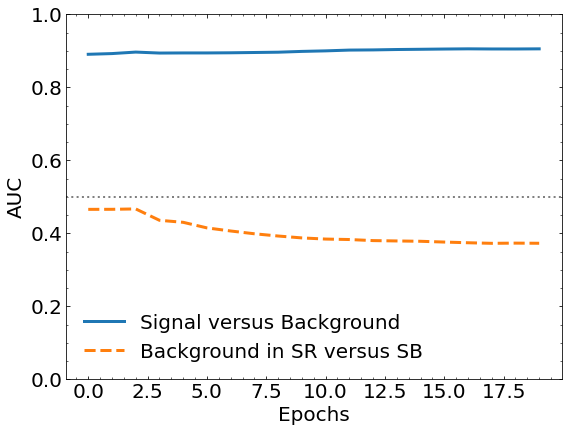

In [29]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

## 4 layers

In [30]:
class AUCRecordsL4(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_4lay, aucsSB_foravg_4lay, aucs_foravg_4lay, aucsSB_foravg_4lay, aucs_4lay, aucs_std_4lay, aucsSB_4lay, aucsSB_std_4lay, num_epochs
        preds_hold_4lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_4lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_4lay = roc_auc_score(Y_test, preds_hold_4lay)
        print(myauc_scan_4lay)
        myaucSB_scan_4lay = roc_auc_score(Y_testSB, preds_holdSB_4lay)
        print(myaucSB_scan_4lay)
        
        aucs_foravg_4lay += [myauc_scan_4lay]
        print(aucs_foravg_4lay)
        aucsSB_foravg_4lay += [myaucSB_scan_4lay]
        print(aucsSB_foravg_4lay)
        
        aucs_4lay+=[np.mean(aucs_foravg_4lay)]
        print(aucs_4lay)
        aucs_std_4lay += [np.std(aucs_foravg_4lay)]
        print(aucs_std_4lay)
        aucsSB_4lay+=[np.mean(aucsSB_foravg_4lay)]
        print(aucsSB_4lay)
        aucsSB_std_4lay += [np.std(aucsSB_foravg_4lay)]
        print(aucsSB_std_4lay)
        
        print(f"epoch {epoch}")

In [31]:
    lambdas_4lay = []
    num_epochs = []
    aucs_4lay = []
    aucs_std_4lay = []
    aucsSB_4lay = []
    aucsSB_std_4lay = []
    aucs_foravg_4lay =[]
    aucsSB_foravg_4lay = []

    for k in range(1):
        model_cwola_scan_4lay = Sequential()
        model_cwola_scan_4lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_4lay.add(Dense(100, activation='relu'))
        model_cwola_scan_4lay.add(Dense(64, activation='relu'))
        model_cwola_scan_4lay.add(Dense(100, activation='relu'))
        model_cwola_scan_4lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_4lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_4lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_4lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_4lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_4lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_4lay = X_kcwola_train_4lay[sb_crit]
        Y_kcwola_train_4lay = Y_kcwola_train_4lay[sb_crit]
        W_kcwola_train_4lay = W_kcwola_train_4lay[sb_crit]


        X_kcwola_train_4lay, Y_kcwola_train_4lay, W_kcwola_train_4lay = shuffle(X_kcwola_train_4lay, Y_kcwola_train_4lay, 
                                                                       W_kcwola_train_4lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_4lay.fit(norm_func(X_kcwola_train_4lay)[:,1:],Y_kcwola_train_4lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_4lay, verbose=2, callbacks=[AUCRecordsL4()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 0s 7ms/step
0.9048772934038399
0.46637060887003123
[0.9048772934038399]
[0.46637060887003123]
[0.9048772934038399]
[0.0]
[0.46637060887003123]
[0.0]
epoch 0
1626/1626 - 7s - loss: 0.6555 - accuracy: 0.5103 - auc: 0.5142 - val_loss: 0.6658 - val_accuracy: 0.7319 - val_auc: 0.9026 - 7s/epoch - 4ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 0s 7ms/step
0.8752323556788255
0.42573692407200747
[0.9048772934038399, 0.8752323556788255]
[0.46637060887003123, 0.42573692407200747]
[0.9048772934038399, 0.8900548245413327]
[0.0, 0.01482246886250721]
[0.46637060887003123, 0.44605376647101935]
[0.0, 0.02031684239901188]
epoch 1
1626/1626 - 6s - loss: 0.6553 - accuracy: 0.5116 - auc: 0.5174 - val_loss: 0.6754 - val_accuracy: 0.8091 - val_auc: 0.8716 - 6s/epoch - 3ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 0s 7ms/step
0.9003752943776834
0.34742881511753126
[0.9048772934038399, 0.8752323556788255, 

epoch 9
Epoch 10/20
50/50 [==============================] - 0s 7ms/step
0.9270260796849021
0.3621727242926725
[0.9048772934038399, 0.8752323556788255, 0.9003752943776834, 0.8974343558374159, 0.8892307951249757, 0.9202977305811457, 0.9105576649331124, 0.9183467161868057, 0.9125053721068243, 0.9270260796849021]
[0.46637060887003123, 0.42573692407200747, 0.34742881511753126, 0.39319696382606445, 0.3052842710056476, 0.34918492761086367, 0.3351550522722527, 0.3285032342717521, 0.3565259648657052, 0.3621727242926725]
[0.9048772934038399, 0.8900548245413327, 0.8934949811534496, 0.8944798248244412, 0.8934300188845482, 0.8979079708339811, 0.8997150699909999, 0.9020440257654756, 0.903206397581181, 0.9055883657915531]
[0.0, 0.01482246886250721, 0.013043762640375165, 0.011424296872574333, 0.010431683338364363, 0.013818234910209835, 0.01353734097894183, 0.014082627442308765, 0.013678218526641694, 0.01481378577046792]
[0.46637060887003123, 0.44605376647101935, 0.41317878268652336, 0.408183327971408

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 7ms/step
0.9272654681569139
0.33445699274704005
[0.9048772934038399, 0.8752323556788255, 0.9003752943776834, 0.8974343558374159, 0.8892307951249757, 0.9202977305811457, 0.9105576649331124, 0.9183467161868057, 0.9125053721068243, 0.9270260796849021, 0.9196284941517386, 0.9170226384275098, 0.9190147526826145, 0.9165084150301822, 0.9272654681569139]
[0.46637060887003123, 0.42573692407200747, 0.34742881511753126, 0.39319696382606445, 0.3052842710056476, 0.34918492761086367, 0.3351550522722527, 0.3285032342717521, 0.3565259648657052, 0.3621727242926725, 0.3449751406901292, 0.3494609019977263, 0.3291357688576874, 0.34592434058755056, 0.33445699274704005]
[0.9048772934038399, 0.8900548245413327, 0.8934949811534496, 0.8944798248244412, 0.8934300188845482, 0.8979079708339811, 0.8997150699909999, 0.9020440257654756, 0.903206397581181, 0.9055883657915531, 0.9068647410970246, 0.9077112325412316, 0.9085807340905687, 0.9091469970148269

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 7ms/step
0.9101946590111949
0.3708182013430821
[0.9048772934038399, 0.8752323556788255, 0.9003752943776834, 0.8974343558374159, 0.8892307951249757, 0.9202977305811457, 0.9105576649331124, 0.9183467161868057, 0.9125053721068243, 0.9270260796849021, 0.9196284941517386, 0.9170226384275098, 0.9190147526826145, 0.9165084150301822, 0.9272654681569139, 0.899259570187037, 0.922961465938206, 0.9173766004280459, 0.9101946590111949]
[0.46637060887003123, 0.42573692407200747, 0.34742881511753126, 0.39319696382606445, 0.3052842710056476, 0.34918492761086367, 0.3351550522722527, 0.3285032342717521, 0.3565259648657052, 0.3621727242926725, 0.3449751406901292, 0.3494609019977263, 0.3291357688576874, 0.34592434058755056, 0.33445699274704005, 0.3696704998876972, 0.3290332092420353, 0.35158263749648694, 0.3708182013430821]
[0.9048772934038399, 0.8900548245413327, 0.8934949811534496, 0.8944798248244412, 0.8934300188845482, 0.8979079708339811,

In [32]:
aucs_4lay = np.asarray(aucs_4lay)
aucs_std_4lay = np.asarray(aucs_std_4lay)

aucsSB_4lay = np.asarray(aucsSB_4lay)
aucsSB_std_4lay = np.asarray(aucsSB_std_4lay)

print(aucs_4lay)
print(aucsSB_4lay)

[0.90487729 0.89005482 0.89349498 0.89447982 0.89343002 0.89790797
 0.89971507 0.90204403 0.9032064  0.90558837 0.90686474 0.90771123
 0.90858073 0.909147   0.9103549  0.90966144 0.91044379 0.91082895
 0.91079556 0.91052847]
[0.46637061 0.44605377 0.41317878 0.40818333 0.38760352 0.38120042
 0.37462251 0.3688576  0.36748742 0.36695595 0.36495769 0.36366629
 0.3610101  0.35993255 0.35823418 0.35894895 0.3571892  0.35687772
 0.35761143 0.35772028]


(0.0, 1.0)

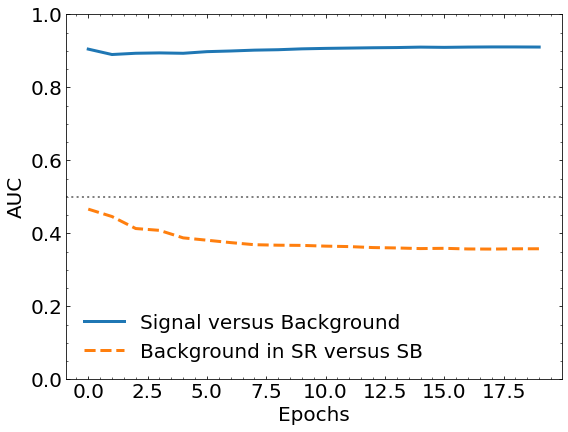

In [33]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

## 5 layers

In [34]:
class AUCRecordsL5(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_5lay, aucsSB_foravg_5lay, aucs_foravg_5lay, aucsSB_foravg_5lay, aucs_5lay, aucs_std_5lay, aucsSB_5lay, aucsSB_std_5lay, num_epochs
        preds_hold_5lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_5lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_5lay = roc_auc_score(Y_test, preds_hold_5lay)
        print(myauc_scan_5lay)
        myaucSB_scan_5lay = roc_auc_score(Y_testSB, preds_holdSB_5lay)
        print(myaucSB_scan_5lay)
        
        aucs_foravg_5lay += [myauc_scan_5lay]
        print(aucs_foravg_5lay)
        aucsSB_foravg_5lay += [myaucSB_scan_5lay]
        print(aucsSB_foravg_5lay)
        
        aucs_5lay+=[np.mean(aucs_foravg_5lay)]
        print(aucs_5lay)
        aucs_std_5lay += [np.std(aucs_foravg_5lay)]
        print(aucs_std_5lay)
        aucsSB_5lay+=[np.mean(aucsSB_foravg_5lay)]
        print(aucsSB_5lay)
        aucsSB_std_5lay += [np.std(aucsSB_foravg_5lay)]
        print(aucsSB_std_5lay)
        
        print(f"epoch {epoch}")

In [35]:
    lambdas_5lay = []
    num_epochs = []
    aucs_5lay = []
    aucs_std_5lay = []
    aucsSB_5lay = []
    aucsSB_std_5lay = []
    aucs_foravg_5lay =[]
    aucsSB_foravg_5lay = []

    for k in range(1):
        model_cwola_scan_5lay = Sequential()
        model_cwola_scan_5lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_5lay.add(Dense(100, activation='relu'))
        model_cwola_scan_5lay.add(Dense(64, activation='relu'))
        model_cwola_scan_5lay.add(Dense(100, activation='relu'))
        model_cwola_scan_5lay.add(Dense(64, activation='relu'))
        model_cwola_scan_5lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_5lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_5lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_5lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_5lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_5lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_5lay = X_kcwola_train_5lay[sb_crit]
        Y_kcwola_train_5lay = Y_kcwola_train_5lay[sb_crit]
        W_kcwola_train_5lay = W_kcwola_train_5lay[sb_crit]


        X_kcwola_train_5lay, Y_kcwola_train_5lay, W_kcwola_train_5lay = shuffle(X_kcwola_train_5lay, Y_kcwola_train_5lay, 
                                                                       W_kcwola_train_5lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_5lay.fit(norm_func(X_kcwola_train_5lay)[:,1:],Y_kcwola_train_5lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_5lay, verbose=2, callbacks=[AUCRecordsL5()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 0s 8ms/step
0.8711860281926025
0.4216598204447823
[0.8711860281926025]
[0.4216598204447823]
[0.8711860281926025]
[0.0]
[0.4216598204447823]
[0.0]
epoch 0
1626/1626 - 8s - loss: 0.6555 - accuracy: 0.5086 - auc: 0.5118 - val_loss: 0.6763 - val_accuracy: 0.5634 - val_auc: 0.8596 - 8s/epoch - 5ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 0s 8ms/step
0.8886530028634766
0.4206907857968574
[0.8711860281926025, 0.8886530028634766]
[0.4216598204447823, 0.4206907857968574]
[0.8711860281926025, 0.8799195155280395]
[0.0, 0.008733487335437051]
[0.4216598204447823, 0.42117530312081985]
[0.0, 0.0004845173239624301]
epoch 1
1626/1626 - 6s - loss: 0.6554 - accuracy: 0.5112 - auc: 0.5159 - val_loss: 0.6826 - val_accuracy: 0.7326 - val_auc: 0.8716 - 6s/epoch - 4ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 0s 8ms/step
0.8596966151862242
0.386130047652413
[0.8711860281926025, 0.8886530028634766, 0.8596

50/50 [==============================] - 0s 8ms/step
0.9092801777373012
0.34953231289176434
[0.8711860281926025, 0.8886530028634766, 0.8596966151862242, 0.8964901028123692, 0.9043617394211181, 0.8916016676052729, 0.9081141237687007, 0.8963625672504166, 0.9006324705704213, 0.9092801777373012]
[0.4216598204447823, 0.4206907857968574, 0.386130047652413, 0.3421101502549444, 0.3691381300912236, 0.32265667842066587, 0.30461551046024543, 0.3281636285980333, 0.3210234367452616, 0.34953231289176434]
[0.8711860281926025, 0.8799195155280395, 0.8731785487474344, 0.8790064372636681, 0.8840774976951581, 0.8853315260135105, 0.8885861828356806, 0.8895582308875226, 0.8907887019634002, 0.8926378495407903]
[0.0, 0.008733487335437051, 0.011905060561232056, 0.01442881505522535, 0.016413871533480822, 0.015243870376236247, 0.016209127620612263, 0.015378816041856482, 0.01491112975722513, 0.015194792938366527]
[0.4216598204447823, 0.42117530312081985, 0.40949355129801757, 0.3926477010372493, 0.3879457868480441

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 8ms/step
0.9266126146641529
0.3434658454645929
[0.8711860281926025, 0.8886530028634766, 0.8596966151862242, 0.8964901028123692, 0.9043617394211181, 0.8916016676052729, 0.9081141237687007, 0.8963625672504166, 0.9006324705704213, 0.9092801777373012, 0.927754619940443, 0.9225481416620485, 0.9160678997640238, 0.921067177936143, 0.9266126146641529]
[0.4216598204447823, 0.4206907857968574, 0.386130047652413, 0.3421101502549444, 0.3691381300912236, 0.32265667842066587, 0.30461551046024543, 0.3281636285980333, 0.3210234367452616, 0.34953231289176434, 0.32866669151791295, 0.34451737495805734, 0.35562269948841435, 0.32008066036534844, 0.3434658454645929]
[0.8711860281926025, 0.8799195155280395, 0.8731785487474344, 0.8790064372636681, 0.8840774976951581, 0.8853315260135105, 0.8885861828356806, 0.8895582308875226, 0.8907887019634002, 0.8926378495407903, 0.8958302832134859, 0.8980567714175328, 0.8994422428288013, 0.9009868810507543, 0

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 8ms/step
0.9161763302181275
0.3448449042928124
[0.8711860281926025, 0.8886530028634766, 0.8596966151862242, 0.8964901028123692, 0.9043617394211181, 0.8916016676052729, 0.9081141237687007, 0.8963625672504166, 0.9006324705704213, 0.9092801777373012, 0.927754619940443, 0.9225481416620485, 0.9160678997640238, 0.921067177936143, 0.9266126146641529, 0.9100194711458242, 0.9112848025118605, 0.9145484242585555, 0.9161763302181275]
[0.4216598204447823, 0.4206907857968574, 0.386130047652413, 0.3421101502549444, 0.3691381300912236, 0.32265667842066587, 0.30461551046024543, 0.3281636285980333, 0.3210234367452616, 0.34953231289176434, 0.32866669151791295, 0.34451737495805734, 0.35562269948841435, 0.32008066036534844, 0.3434658454645929, 0.3725833724786705, 0.30564383792846284, 0.37097782628586484, 0.3448449042928124]
[0.8711860281926025, 0.8799195155280395, 0.8731785487474344, 0.8790064372636681, 0.8840774976951581, 0.8853315260135105,

In [36]:
aucs_5lay = np.asarray(aucs_5lay)
aucs_std_5lay = np.asarray(aucs_std_5lay)

aucsSB_5lay = np.asarray(aucsSB_5lay)
aucsSB_std_5lay = np.asarray(aucsSB_std_5lay)

print(aucs_5lay)
print(aucsSB_5lay)

[0.87118603 0.87991952 0.87317855 0.87900644 0.8840775  0.88533153
 0.88858618 0.88955823 0.8907887  0.89263785 0.89583028 0.89805677
 0.89944224 0.90098688 0.90269526 0.90315303 0.90363137 0.90423787
 0.90486621 0.90565959]
[0.42165982 0.4211753  0.40949355 0.3926477  0.38794579 0.37706427
 0.36671445 0.36189559 0.35735424 0.35657205 0.3540352  0.35324205
 0.35342517 0.35104342 0.35053825 0.35191607 0.34919418 0.35040438
 0.35011177 0.34984503]


(0.0, 1.0)

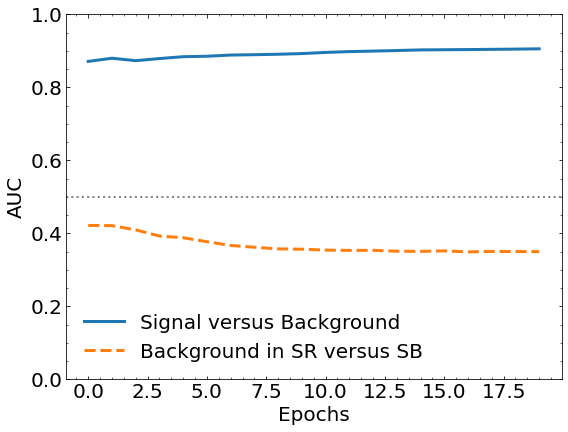

In [37]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

# AUC all architectures

C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\2768153683.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

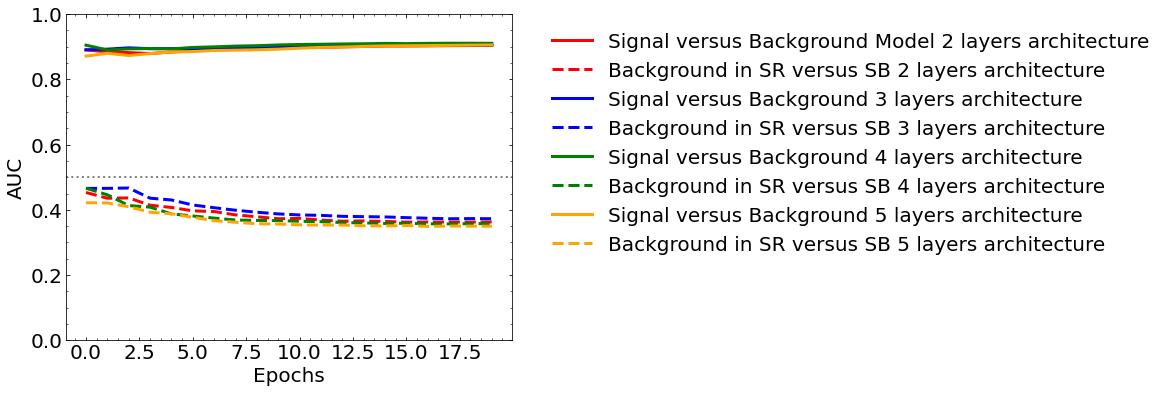

In [38]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [39]:
class AUCRecordsL15(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_15lay, aucsSB_foravg_15lay, aucs_foravg_15lay, aucsSB_foravg_15lay, aucs_15lay, aucs_std_15lay, aucsSB_15lay, aucsSB_std_15lay, num_epochs
        preds_hold_15lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_15lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_15lay = roc_auc_score(Y_test, preds_hold_15lay)
        print(myauc_scan_15lay)
        myaucSB_scan_15lay = roc_auc_score(Y_testSB, preds_holdSB_15lay)
        print(myaucSB_scan_15lay)
        
        aucs_foravg_15lay += [myauc_scan_15lay]
        print(aucs_foravg_15lay)
        aucsSB_foravg_15lay += [myaucSB_scan_15lay]
        print(aucsSB_foravg_15lay)
        
        aucs_15lay+=[np.mean(aucs_foravg_15lay)]
        print(aucs_15lay)
        aucs_std_15lay += [np.std(aucs_foravg_15lay)]
        print(aucs_std_15lay)
        aucsSB_15lay+=[np.mean(aucsSB_foravg_15lay)]
        print(aucsSB_15lay)
        aucsSB_std_15lay += [np.std(aucsSB_foravg_15lay)]
        print(aucsSB_std_15lay)
        
        print(f"epoch {epoch}")

In [40]:
    lambdas_15lay = []
    num_epochs = []
    aucs_15lay = []
    aucs_std_15lay = []
    aucsSB_15lay = []
    aucsSB_std_15lay = []
    aucs_foravg_15lay =[]
    aucsSB_foravg_15lay = []

    for k in range(1):
        model_cwola_scan_15lay = Sequential()
        model_cwola_scan_15lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_15lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_15lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_15lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_15lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_15lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_15lay = X_kcwola_train_15lay[sb_crit]
        Y_kcwola_train_15lay = Y_kcwola_train_15lay[sb_crit]
        W_kcwola_train_15lay = W_kcwola_train_15lay[sb_crit]


        X_kcwola_train_15lay, Y_kcwola_train_15lay, W_kcwola_train_15lay = shuffle(X_kcwola_train_15lay, Y_kcwola_train_15lay, 
                                                                       W_kcwola_train_15lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_15lay.fit(norm_func(X_kcwola_train_15lay)[:,1:],Y_kcwola_train_15lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_15lay, verbose=2, callbacks=[AUCRecordsL15()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 1s 21ms/step
0.5
0.5
[0.5]
[0.5]
[0.5]
[0.0]
[0.5]
[0.0]
epoch 0
1626/1626 - 13s - loss: 0.6557 - accuracy: 0.5008 - auc: 0.5006 - val_loss: 0.6940 - val_accuracy: 0.4495 - val_auc: 0.5000 - 13s/epoch - 8ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 1s 21ms/step
0.5
0.5
[0.5, 0.5]
[0.5, 0.5]
[0.5, 0.5]
[0.0, 0.0]
[0.5, 0.5]
[0.0, 0.0]
epoch 1
1626/1626 - 10s - loss: 0.6557 - accuracy: 0.4998 - auc: 0.4986 - val_loss: 0.6933 - val_accuracy: 0.4495 - val_auc: 0.5000 - 10s/epoch - 6ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 1s 21ms/step
0.5
0.5
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
[0.0, 0.0, 0.0]
[0.5, 0.5, 0.5]
[0.0, 0.0, 0.0]
epoch 2
1626/1626 - 10s - loss: 0.6557 - accuracy: 0.4986 - auc: 0.4996 - val_loss: 0.6933 - val_accuracy: 0.4495 - val_auc: 0.5000 - 10s/epoch - 6ms/step
epoch 3
Epoch 4/20
50/50 [==============================] - 1s 21ms/step
0.5
0.5
[0.5, 0.5, 0.

epoch 14
Epoch 15/20
50/50 [==============================] - 1s 22ms/step
0.5
0.5
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49997527852857804, 0.5, 0.500024721471422, 0.5, 0.5, 0.49997527852857804, 0.5, 0.5]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999690981607225, 0.499997253169842, 0.5, 0.5, 0.5, 0.4999980983483522, 0.49999823418061273, 0.4999983519019052]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.175858178262838e-06, 7.769208925946232e-06, 1.1055778120665239e-05, 1.0541270833054249e-05, 1.0092498445767373e-05, 1.1722568046734005e-05, 1.130676091764076e-05, 1.0932245996285719e-05]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
epoch 14
1626/1626 - 10s - loss: 0.6557 - accuracy: 0.4999 - auc: 0.5015 - val_loss: 0.6923 - val_accuracy: 0.5505 - val_auc: 0.5000 - 10s/epoch - 6ms/step
epoch 15
Epoch 16/20
50/50 [======

In [41]:
aucs_15lay = np.asarray(aucs_15lay)
aucs_std_15lay = np.asarray(aucs_std_15lay)

aucsSB_15lay = np.asarray(aucsSB_15lay)
aucsSB_std_15lay = np.asarray(aucsSB_std_15lay)

print(aucs_15lay)
print(aucsSB_15lay)

[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.49999691 0.49999725 0.5        0.5        0.5
 0.4999981  0.49999823 0.49999835 0.49999845 0.49999855 0.49999863
 0.4999987  0.49999876]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\4093967315.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

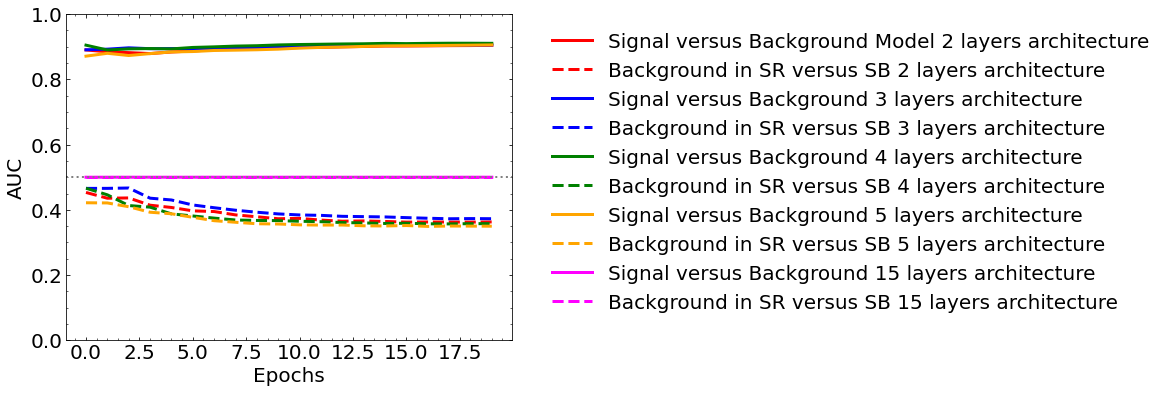

In [42]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.plot(num_epochs, aucs_15lay,label="Signal versus Background 15 layers architecture",linewidth=3,color='magenta')
plt.plot(num_epochs, aucsSB_15lay,label="Background in SR versus SB 15 layers architecture",ls="--",linewidth=3,color='magenta')

plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [43]:
class AUCRecordsL9(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_9lay, aucsSB_foravg_9lay, aucs_foravg_9lay, aucsSB_foravg_9lay, aucs_9lay, aucs_std_9lay, aucsSB_9lay, aucsSB_std_9lay, num_epochs
        preds_hold_9lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_9lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_9lay = roc_auc_score(Y_test, preds_hold_9lay)
        print(myauc_scan_9lay)
        myaucSB_scan_9lay = roc_auc_score(Y_testSB, preds_holdSB_9lay)
        print(myaucSB_scan_9lay)
        
        aucs_foravg_9lay += [myauc_scan_9lay]
        print(aucs_foravg_9lay)
        aucsSB_foravg_9lay += [myaucSB_scan_9lay]
        print(aucsSB_foravg_9lay)
        
        aucs_9lay+=[np.mean(aucs_foravg_9lay)]
        print(aucs_9lay)
        aucs_std_9lay += [np.std(aucs_foravg_9lay)]
        print(aucs_std_9lay)
        aucsSB_9lay+=[np.mean(aucsSB_foravg_9lay)]
        print(aucsSB_9lay)
        aucsSB_std_9lay += [np.std(aucsSB_foravg_9lay)]
        print(aucsSB_std_9lay)
        
        print(f"epoch {epoch}")

In [44]:
    lambdas_9lay = []
    num_epochs = []
    aucs_9lay = []
    aucs_std_9lay = []
    aucsSB_9lay = []
    aucsSB_std_9lay = []
    aucs_foravg_9lay =[]
    aucsSB_foravg_9lay = []

    for k in range(1):
        model_cwola_scan_9lay = Sequential()
        model_cwola_scan_9lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_9lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_9lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_9lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_9lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_9lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_9lay = X_kcwola_train_9lay[sb_crit]
        Y_kcwola_train_9lay = Y_kcwola_train_9lay[sb_crit]
        W_kcwola_train_9lay = W_kcwola_train_9lay[sb_crit]


        X_kcwola_train_9lay, Y_kcwola_train_9lay, W_kcwola_train_9lay = shuffle(X_kcwola_train_9lay, Y_kcwola_train_9lay, 
                                                                       W_kcwola_train_9lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_9lay.fit(norm_func(X_kcwola_train_9lay)[:,1:],Y_kcwola_train_9lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_9lay, verbose=2, callbacks=[AUCRecordsL9()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 1s 13ms/step
0.8990825139344399
0.5194291715183879
[0.8990825139344399]
[0.5194291715183879]
[0.8990825139344399]
[0.0]
[0.5194291715183879]
[0.0]
epoch 0
1626/1626 - 10s - loss: 0.6557 - accuracy: 0.5018 - auc: 0.5008 - val_loss: 0.6892 - val_accuracy: 0.8141 - val_auc: 0.7666 - 10s/epoch - 6ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 1s 13ms/step
0.8762136789881969
0.4748496623348004
[0.8990825139344399, 0.8762136789881969]
[0.5194291715183879, 0.4748496623348004]
[0.8990825139344399, 0.8876480964613185]
[0.0, 0.011434417473121516]
[0.5194291715183879, 0.49713941692659414]
[0.0, 0.02228975459179372]
epoch 1
1626/1626 - 7s - loss: 0.6555 - accuracy: 0.5086 - auc: 0.5115 - val_loss: 0.6796 - val_accuracy: 0.6284 - val_auc: 0.8605 - 7s/epoch - 4ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 1s 13ms/step
0.909231830916442
0.46714698105925434
[0.8990825139344399, 0.8762136789881969, 0.

50/50 [==============================] - 1s 13ms/step
0.8973370397696552
0.31430935641502145
[0.8990825139344399, 0.8762136789881969, 0.909231830916442, 0.8927269108550713, 0.8900731190091344, 0.8906267649776608, 0.8726755163381819, 0.8736211243487886, 0.8937686266816018, 0.8973370397696552]
[0.5194291715183879, 0.4748496623348004, 0.46714698105925434, 0.4304396010548546, 0.39993937672738217, 0.37692655096498745, 0.3159812702895827, 0.31574960282262965, 0.3350540148975991, 0.31430935641502145]
[0.8990825139344399, 0.8876480964613185, 0.8948426746130264, 0.8943137336735376, 0.8934656107406569, 0.8929924697801576, 0.8900900478598753, 0.8880314324209895, 0.8886688984499465, 0.8895357125819172]
[0.0, 0.011434417473121516, 0.013808976966517656, 0.01199396594954159, 0.01086100480600771, 0.009970982883979561, 0.011651690399592822, 0.012184290529140468, 0.011628096324226235, 0.011333739999108644]
[0.5194291715183879, 0.49713941692659414, 0.48714193830414754, 0.4729663539918243, 0.4583609585389

epoch 14
Epoch 15/20
50/50 [==============================] - 1s 13ms/step
0.9088357802938852
0.32021225455924474
[0.8990825139344399, 0.8762136789881969, 0.909231830916442, 0.8927269108550713, 0.8900731190091344, 0.8906267649776608, 0.8726755163381819, 0.8736211243487886, 0.8937686266816018, 0.8973370397696552, 0.9049333291605206, 0.8959201274766511, 0.9008674621325912, 0.9020900105809855, 0.9088357802938852]
[0.5194291715183879, 0.4748496623348004, 0.46714698105925434, 0.4304396010548546, 0.39993937672738217, 0.37692655096498745, 0.3159812702895827, 0.31574960282262965, 0.3350540148975991, 0.31430935641502145, 0.3330764046251129, 0.30760514297501496, 0.3157669063257885, 0.3743796942115935, 0.32021225455924474]
[0.8990825139344399, 0.8876480964613185, 0.8948426746130264, 0.8943137336735376, 0.8934656107406569, 0.8929924697801576, 0.8900900478598753, 0.8880314324209895, 0.8886688984499465, 0.8895357125819172, 0.8909354959072449, 0.8913508818713621, 0.8920829265068413, 0.892797718226423

epoch 18
Epoch 19/20
50/50 [==============================] - 1s 13ms/step
0.9193955743854483
0.3518583616809877
[0.8990825139344399, 0.8762136789881969, 0.909231830916442, 0.8927269108550713, 0.8900731190091344, 0.8906267649776608, 0.8726755163381819, 0.8736211243487886, 0.8937686266816018, 0.8973370397696552, 0.9049333291605206, 0.8959201274766511, 0.9008674621325912, 0.9020900105809855, 0.9088357802938852, 0.9157344221461525, 0.9081165620107039, 0.9050335946537538, 0.9193955743854483]
[0.5194291715183879, 0.4748496623348004, 0.46714698105925434, 0.4304396010548546, 0.39993937672738217, 0.37692655096498745, 0.3159812702895827, 0.31574960282262965, 0.3350540148975991, 0.31430935641502145, 0.3330764046251129, 0.30760514297501496, 0.3157669063257885, 0.3743796942115935, 0.32021225455924474, 0.32440643781103884, 0.3681460785141537, 0.33732962770001396, 0.3518583616809877]
[0.8990825139344399, 0.8876480964613185, 0.8948426746130264, 0.8943137336735376, 0.8934656107406569, 0.89299246978015

In [45]:
aucs_9lay = np.asarray(aucs_9lay)
aucs_std_9lay = np.asarray(aucs_std_9lay)

aucsSB_9lay = np.asarray(aucsSB_9lay)
aucsSB_std_9lay = np.asarray(aucsSB_std_9lay)

print(aucs_9lay)
print(aucsSB_9lay)

[0.89908251 0.8876481  0.89484267 0.89431373 0.89346561 0.89299247
 0.89009005 0.88803143 0.8886689  0.88953571 0.8909355  0.89135088
 0.89208293 0.89279772 0.89386692 0.89523364 0.89599146 0.8964938
 0.89769916 0.89806282]
[0.51942917 0.49713942 0.48714194 0.47296635 0.45836096 0.44478856
 0.42638752 0.41255778 0.40394625 0.39498256 0.38935473 0.38254226
 0.3774057  0.37718955 0.37339107 0.37032953 0.37020109 0.3683749
 0.36750561 0.3656152 ]


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\656470828.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

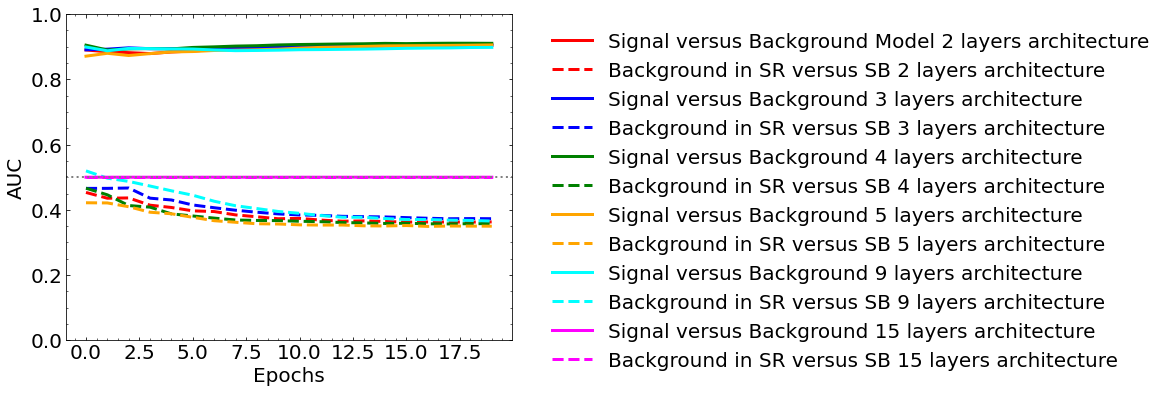

In [46]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.plot(num_epochs, aucs_9lay,label="Signal versus Background 9 layers architecture",linewidth=3,color='cyan')
plt.plot(num_epochs, aucsSB_9lay,label="Background in SR versus SB 9 layers architecture",ls="--",linewidth=3,color='cyan')

plt.plot(num_epochs, aucs_15lay,label="Signal versus Background 15 layers architecture",linewidth=3,color='magenta')
plt.plot(num_epochs, aucsSB_15lay,label="Background in SR versus SB 15 layers architecture",ls="--",linewidth=3,color='magenta')

plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [47]:
class AUCRecordsL11(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_11lay, aucsSB_foravg_11lay, aucs_foravg_11lay, aucsSB_foravg_11lay, aucs_11lay, aucs_std_11lay, aucsSB_11lay, aucsSB_std_11lay, num_epochs
        preds_hold_11lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_11lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_11lay = roc_auc_score(Y_test, preds_hold_11lay)
        print(myauc_scan_11lay)
        myaucSB_scan_11lay = roc_auc_score(Y_testSB, preds_holdSB_11lay)
        print(myaucSB_scan_11lay)
        
        aucs_foravg_11lay += [myauc_scan_11lay]
        print(aucs_foravg_11lay)
        aucsSB_foravg_11lay += [myaucSB_scan_11lay]
        print(aucsSB_foravg_11lay)
        
        aucs_11lay+=[np.mean(aucs_foravg_11lay)]
        print(aucs_11lay)
        aucs_std_11lay += [np.std(aucs_foravg_11lay)]
        print(aucs_std_11lay)
        aucsSB_11lay+=[np.mean(aucsSB_foravg_11lay)]
        print(aucsSB_11lay)
        aucsSB_std_11lay += [np.std(aucsSB_foravg_11lay)]
        print(aucsSB_std_11lay)
        
        print(f"epoch {epoch}")

In [48]:
    lambdas_11lay = []
    num_epochs = []
    aucs_11lay = []
    aucs_std_11lay = []
    aucsSB_11lay = []
    aucsSB_std_11lay = []
    aucs_foravg_11lay =[]
    aucsSB_foravg_11lay = []

    for k in range(1):
        model_cwola_scan_11lay = Sequential()
        model_cwola_scan_11lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_11lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_11lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_11lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_11lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_11lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_11lay = X_kcwola_train_11lay[sb_crit]
        Y_kcwola_train_11lay = Y_kcwola_train_11lay[sb_crit]
        W_kcwola_train_11lay = W_kcwola_train_11lay[sb_crit]


        X_kcwola_train_11lay, Y_kcwola_train_11lay, W_kcwola_train_11lay = shuffle(X_kcwola_train_11lay, Y_kcwola_train_11lay, 
                                                                       W_kcwola_train_11lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_11lay.fit(norm_func(X_kcwola_train_11lay)[:,1:],Y_kcwola_train_11lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_11lay, verbose=2, callbacks=[AUCRecordsL11()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 1s 15ms/step
0.9141211212384328
0.5528985580222237
[0.9141211212384328]
[0.5528985580222237]
[0.9141211212384328]
[0.0]
[0.5528985580222237]
[0.0]
epoch 0
1626/1626 - 10s - loss: 0.6557 - accuracy: 0.5026 - auc: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.4495 - val_auc: 0.5000 - 10s/epoch - 6ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 1s 15ms/step
0.5
0.5
[0.9141211212384328, 0.5]
[0.5528985580222237, 0.5]
[0.9141211212384328, 0.7070605606192164]
[0.0, 0.2070605606192164]
[0.5528985580222237, 0.5264492790111118]
[0.0, 0.026449279011111826]
epoch 1
1626/1626 - 8s - loss: 0.6557 - accuracy: 0.5011 - auc: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4495 - val_auc: 0.5000 - 8s/epoch - 5ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 1s 16ms/step
0.5
0.5
[0.9141211212384328, 0.5, 0.5]
[0.5528985580222237, 0.5, 0.5]
[0.9141211212384328, 0.7070605606192164, 0.6380403737461443]
[0.0, 0.2070

epoch 11
Epoch 12/20
50/50 [==============================] - 1s 15ms/step
0.5
0.5
[0.9141211212384328, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500024721471422, 0.5]
[0.5528985580222237, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.9141211212384328, 0.7070605606192164, 0.6380403737461443, 0.6035302803096082, 0.5828242242476865, 0.5690201868730721, 0.5591601601769189, 0.551765140154804, 0.5460134579153814, 0.5414121121238432, 0.5376496220645323, 0.5345121535591545]
[0.0, 0.2070605606192164, 0.19521856870684814, 0.1793197056180891, 0.1656484484953731, 0.15433382966792794, 0.14491220553477283, 0.13695768743201525, 0.1301457124712321, 0.12423633637152985, 0.11905074136278067, 0.11445641046101347]
[0.5528985580222237, 0.5264492790111118, 0.5176328526740746, 0.513224639505556, 0.5105797116044448, 0.5088164263370373, 0.5075569368603177, 0.506612319752778, 0.5058776175580249, 0.5052898558022224, 0.5048089598202021, 0.5044082131685187]
[0.0, 0.026449279011111826, 0.024936619

epoch 17
Epoch 18/20
50/50 [==============================] - 1s 15ms/step
0.500024721471422
0.5
[0.9141211212384328, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500024721471422, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500024721471422]
[0.5528985580222237, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.9141211212384328, 0.7070605606192164, 0.6380403737461443, 0.6035302803096082, 0.5828242242476865, 0.5690201868730721, 0.5591601601769189, 0.551765140154804, 0.5460134579153814, 0.5414121121238432, 0.5376496220645323, 0.5345121535591545, 0.5318573725161426, 0.5295818459078467, 0.5276097228473237, 0.525884115169366, 0.5243615201594033, 0.5230094757878487]
[0.0, 0.2070605606192164, 0.19521856870684814, 0.1793197056180891, 0.1656484484953731, 0.15433382966792794, 0.14491220553477283, 0.13695768743201525, 0.1301457124712321, 0.12423633637152985, 0.11905074136278067, 0.11445641046101347, 0.11035003930838527, 0.1066520059300037, 0.1032995165304393, 0.10024236

In [49]:
aucs_11lay = np.asarray(aucs_11lay)
aucs_std_11lay = np.asarray(aucs_std_11lay)

aucsSB_11lay = np.asarray(aucsSB_11lay)
aucsSB_std_11lay = np.asarray(aucsSB_std_11lay)

print(aucs_11lay)
print(aucsSB_11lay)

[0.91412112 0.70706056 0.63804037 0.60353028 0.58282422 0.56902019
 0.55916016 0.55176514 0.54601346 0.54141211 0.53764962 0.53451215
 0.53185737 0.52958185 0.52760972 0.52588412 0.52436152 0.52300948
 0.52179845 0.52070976]
[0.55289856 0.52644928 0.51763285 0.51322464 0.51057971 0.50881643
 0.50755694 0.50661232 0.50587762 0.50528986 0.50480896 0.50440821
 0.50406912 0.50377847 0.50352657 0.50330616 0.50311168 0.50293881
 0.50278413 0.50264493]


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\2256482834.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

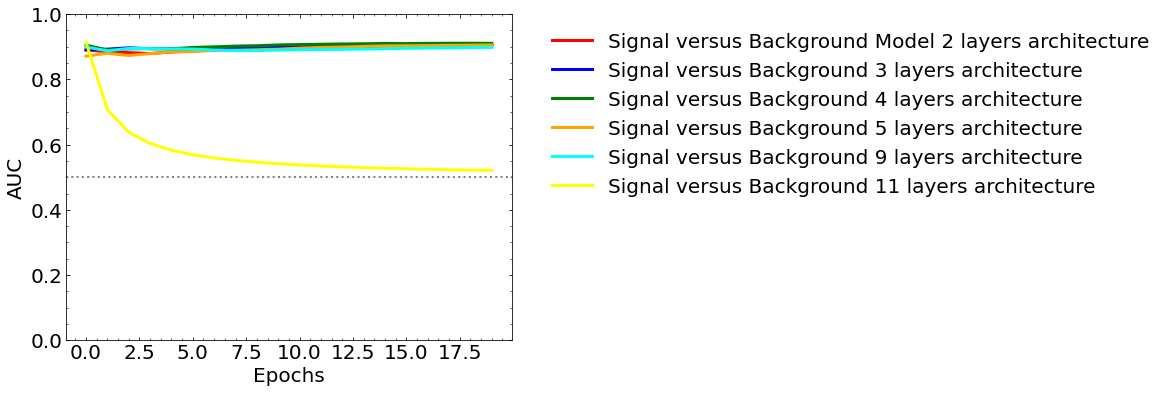

In [50]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
#plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
#plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
#plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
#plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.plot(num_epochs, aucs_9lay,label="Signal versus Background 9 layers architecture",linewidth=3,color='cyan')
#plt.plot(num_epochs, aucsSB_9lay,label="Background in SR versus SB 9 layers architecture",ls="--",linewidth=3,color='cyan')

plt.plot(num_epochs, aucs_11lay,label="Signal versus Background 11 layers architecture",linewidth=3,color='yellow')
#plt.plot(num_epochs, aucsSB_11lay,label="Background in SR versus SB 11 layers architecture",ls="--",linewidth=3,color='yellow')

#plt.plot(num_epochs, aucs_15lay,label="Signal versus Background 15 layers architecture",linewidth=3,color='magenta')
#plt.plot(num_epochs, aucsSB_15lay,label="Background in SR versus SB 15 layers architecture",ls="--",linewidth=3,color='magenta')



plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [51]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT21, bg2_srsbT21, sig_srsbT21 = sr_crit(dataset_bgT21), sr_crit(dataset_bg2T21), sr_crit(dataset_sigT21)

SR_background_dataT21 = dataset_bgT21[bg_srsbT21]
SB_background_dataT21 = dataset_bgT21[~bg_srsbT21]

SR_background_simT21 = dataset_bg2T21[bg2_srsbT21]
SB_background_simT21 = dataset_bg2T21[~bg2_srsbT21]

SR_signalT21 = dataset_sigT21[sig_srsbT21]
SB_signalT21 = dataset_sigT21[~sig_srsbT21]

N_inputs = len(SR_background_dataT21.T) - 1


((SR_background_dataT21, SR_background_data_fortestT21),
 (SR_background_simT21, SR_background_sim_fortestT21),
 (SB_background_dataT21, SB_background_data_fortestT21),
 (SB_background_simT21, SB_background_sim_fortestT21),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT21, SR_background_simT21,
    SB_background_dataT21, SB_background_simT21,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT21, SB_background_simT21, SR_background_dataT21, 
                                      SR_background_simT21]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT21)*Nsig/len(SR_signalT21)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)))

n_injectionsT21 = 20
SR_signals_to_injectT21 = [None] * n_injectionsT21
SB_signals_to_injectT21 = [None] * n_injectionsT21
signals_to_testT21 = [None] * n_injectionsT21

for i in range(n_injectionsT21):
    idx = np.isin(range(len(SR_signalT21)), np.random.choice(SR_signalT21.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT21[i] = SR_signalT21[idx, :]
    signals_to_testT21[i] = SR_signalT21[~idx, :]
    
    idx = np.isin(range(len(SB_signalT21)), np.random.choice(SB_signalT21.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT21[i] = SB_signalT21[idx, :]

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


In [52]:
#CWoLa with T21 and relu 
cwola_rocsT21 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21 = Sequential()
    model_cwolaT21.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT21.add(Dense(100, activation='relu'))
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(100, activation='relu'))
    model_cwolaT21.add(Dense(1, activation='sigmoid'))
    model_cwolaT21.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21 = model_cwolaT21.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21 = model_cwolaT21.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21, tpr_cwolaT21, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21)
    cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:35<30:05, 95.03s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:10<28:33, 95.20s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:47<27:14, 96.16s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:18<25:05, 94.12s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:49<23:16, 93.09s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:23<21:45, 93.27s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:56<20:11, 93.16s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:29<18:38, 93.17s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [14:02<17:03, 93.06s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:35<15:31, 93.14s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [17:11<14:04, 93.81s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:46<12:34, 94.31s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [20:21<11:01, 94.57s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:57<09:28, 94.81s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [23:33<07:56, 95.21s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [25:04<06:16, 94.02s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:36<04:39, 93.31s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [28:09<03:06, 93.46s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:40<01:32, 92.54s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_21988\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [31:10<00:00, 93.54s/it]


In [53]:
 with np.errstate(divide='ignore'):
    tpr_pts = np.linspace(0, 1, 10000)
    
    # CWoLa T21
    fpr_interp = [None] * len(cwola_rocsT21)

    for i, row in cwola_rocsT21.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21 = np.median(fpr_interp, axis=0).data
    cwola_meanT21 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21 = np.nanstd(sig_interp, axis=0).data
    
    
   

C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [54]:
bands_T21 = {'cwola_T21': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'$T_{21}$', 'color':'blue'}),}